In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preprocessing

In [79]:
import pandas as pd
import shutil
import os
import sys

labels = pd.read_csv('labels.csv')

# Create `train_sep` directory
train_dir = 'train/'
train_sep_dir = 'train_sep/'
if not os.path.exists(train_sep_dir):
    os.mkdir(train_sep_dir)

for filename, class_name in labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(train_sep_dir + class_name):
        os.mkdir(train_sep_dir + class_name)
    src_path = train_dir + filename + '.jpg'
    dst_path = train_sep_dir + class_name + '/' + filename + '.jpg'
    try:
        shutil.copy(src_path, dst_path)
    except IOError as e:
        print('Unable to copy file {} to {}'
              .format(src_path, dst_path))
    except:
        print('When try copy file {} to {}, unexpected error: {}'
              .format(src_path, dst_path, sys.exc_info()))
        



In [45]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [46]:
train_generator = datagen.flow_from_directory(
    'train_sep/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    'train_sep/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 8221 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.


In [47]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 120))

In [50]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

# 2. Creating the base model

In [51]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

#the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 123s 13us/step


# 3. Feature Extraction

In [52]:
base_model.trainable = False

# 4. Adding a classification head

In [54]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(120, activation='softmax')
])

# 5. Compile the model

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3960      
Total params: 2,630,616
Trainable params: 372,632
Non-trainable params: 2,257,984
_________________________________________________________________
Number of trainable variables = 4


# 6. Training The model

In [56]:
epochs = 10

history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 129 steps, validate for 32 steps
Epoch 1/10
129/129 [==============================] - 441s 3s/step - loss: 4.0699 - accuracy: 0.1185 - val_loss: 3.2822 - val_accuracy: 0.2274
Epoch 2/10
129/129 [==============================] - 440s 3s/step - loss: 2.5149 - accuracy: 0.3691 - val_loss: 2.2816 - val_accuracy: 0.4158
Epoch 3/10
129/129 [==============================] - 449s 3s/step - loss: 1.7439 - accuracy: 0.5261 - val_loss: 2.1511 - val_accuracy: 0.4568
Epoch 4/10
129/129 [==============================] - 394s 3s/step - loss: 1.4024 - accuracy: 0.5986 - val_loss: 2.0638 - val_accuracy: 0.4818
Epoch 5/10
129/129 [==============================] - 379s 3s/step - loss: 1.1854 - accuracy: 0.6508 - val_loss: 1.9794 - val_accuracy: 0.5037
Epoch 6/10
129/129 [==============================] - 386s 3s/step - loss: 1.0475 - accuracy: 0.6858 - val_loss: 2.0

# 7. Learning Curves


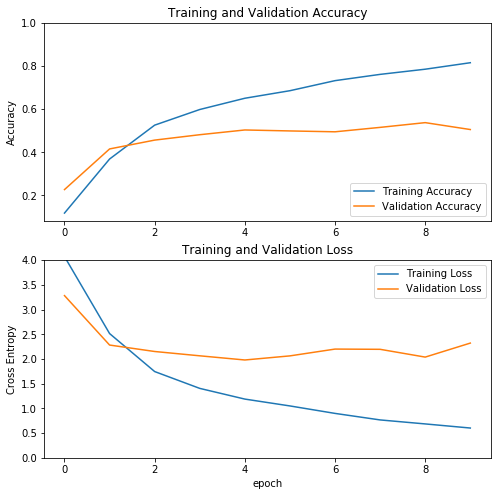

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 8. Fine Tuning

8.1 Un-freeze the top layers

In [61]:
base_model.trainable = True

In [62]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


8.2 Compile the model

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3960      
Total params: 2,630,616
Trainable params: 2,235,224
Non-trainable params: 395,392
_________________________________________________________________
Number of trainable variables = 60


8.3 Continue Training

In [64]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 129 steps, validate for 32 steps
Epoch 1/5
129/129 [==============================] - 488s 4s/step - loss: 0.4257 - accuracy: 0.8875 - val_loss: 2.1824 - val_accuracy: 0.5262
Epoch 2/5
129/129 [==============================] - 554s 4s/step - loss: 0.3166 - accuracy: 0.9228 - val_loss: 2.1736 - val_accuracy: 0.5327
Epoch 3/5
129/129 [==============================] - 554s 4s/step - loss: 0.2575 - accuracy: 0.9449 - val_loss: 2.1760 - val_accuracy: 0.5337
Epoch 4/5
129/129 [==============================] - 539s 4s/step - loss: 0.2098 - accuracy: 0.9629 - val_loss: 2.1970 - val_accuracy: 0.5297
Epoch 5/5
129/129 [==============================] - 469s 4s/step - loss: 0.1805 - accuracy: 0.9689 - val_loss: 2.1948 - val_accuracy: 0.5377


# 9. Learning Curves 

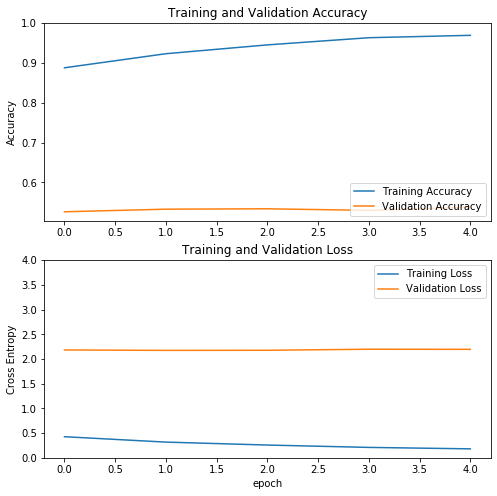

In [66]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 10. Saving to file

In [68]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: save/fine_tuning/assets


# 11. Testing 

[[8.0499453e-20 1.1569324e-08 4.4940815e-11 1.5147782e-08 9.4998627e-11
  1.0315532e-05 5.9596875e-08 2.7021136e-09 3.8888994e-09 6.4148459e-08
  1.2091098e-17 1.9187553e-07 2.9392504e-08 4.1340638e-12 9.7436314e-05
  1.2201068e-10 2.2798456e-07 1.4738112e-10 1.6250514e-08 3.3072663e-16
  2.7710268e-11 4.2460755e-14 1.5193766e-11 8.1331258e-10 1.2267028e-11
  2.9823410e-10 3.9063600e-10 5.4878632e-07 3.1250212e-07 1.0482968e-10
  2.9175528e-05 7.3730591e-11 1.1755548e-12 2.5050886e-05 1.3771962e-09
  1.2217857e-10 2.9367527e-07 2.2592558e-05 6.9589866e-08 5.7400979e-07
  2.8293989e-09 2.4286707e-18 1.4057204e-09 3.6281359e-01 2.6904461e-08
  3.2169264e-14 1.8487368e-05 1.1426671e-11 3.6231174e-13 1.1447698e-04
  1.5741859e-08 2.6384508e-10 2.7485532e-05 3.9481165e-08 2.5882111e-06
  6.1261253e-11 6.6747454e-13 1.4922353e-08 4.4812058e-12 2.8773632e-08
  3.6928846e-10 5.1789199e-13 9.9211297e-07 2.5164331e-07 1.2437468e-17
  1.0266366e-08 2.4275439e-08 5.3555385e-04 2.7270462e-11 3.5881

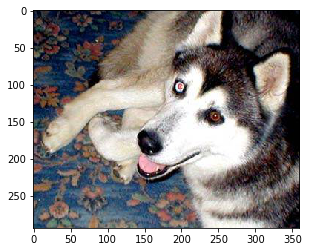

In [106]:
from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (IMAGE_SIZE, IMAGE_SIZE, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('test/test2.jpg')
probabilities = model.predict(image)
print(probabilities[0:1])
pred_indx = np.argmax(probabilities,-1)

print("")

fp = open("labels.txt")
for i, line in enumerate(fp):
    if i == pred_indx:
        print(line)
        break
fp.close()

img=mpimg.imread('test/test2.jpg')
imgplot = plt.imshow(img)
plt.show()


